### ИАД1. ДЗ5
#### Лайко Рудольф

In [169]:
import quandl
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
plt.style.use("ggplot")
%matplotlib inline

from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from scipy import stats

from itertools import product
import datetime
from dateutil.relativedelta import relativedelta

* для анализа возьмем данные по [сокровищнице США](https://www.quandl.com/data/FMSTREAS-US-Treasury-Financial-Management-Service) (по ссылке можно получить данные и пакет quandl, c помощью которого читаю данные в DataFrame)

In [2]:
data = quandl.get("FMSTREAS/MTS")

In [3]:
data.tail()

,Receipts,Outlays,Deficit/Surplus (-),Borrowing from the Public,Reduction of Operating Cash,By Other Means
Date,,,,,,
2016-07-16,209998.0,322817.0,112815.0,66778.0,29914.0,16123.0
2016-08-16,231327.0,338438.0,107112.0,105761.0,44802.0,-43452.0
2016-09-16,356623.0,323178.0,-33359.0,68480.0,-64365.0,-37474.0
2016-10-16,221692.0,265884.0,44192.0,112656.0,-68256.0,-208.0
2016-11-16,199875.0,336526.0,136651.0,156727.0,-467.0,-19609.0


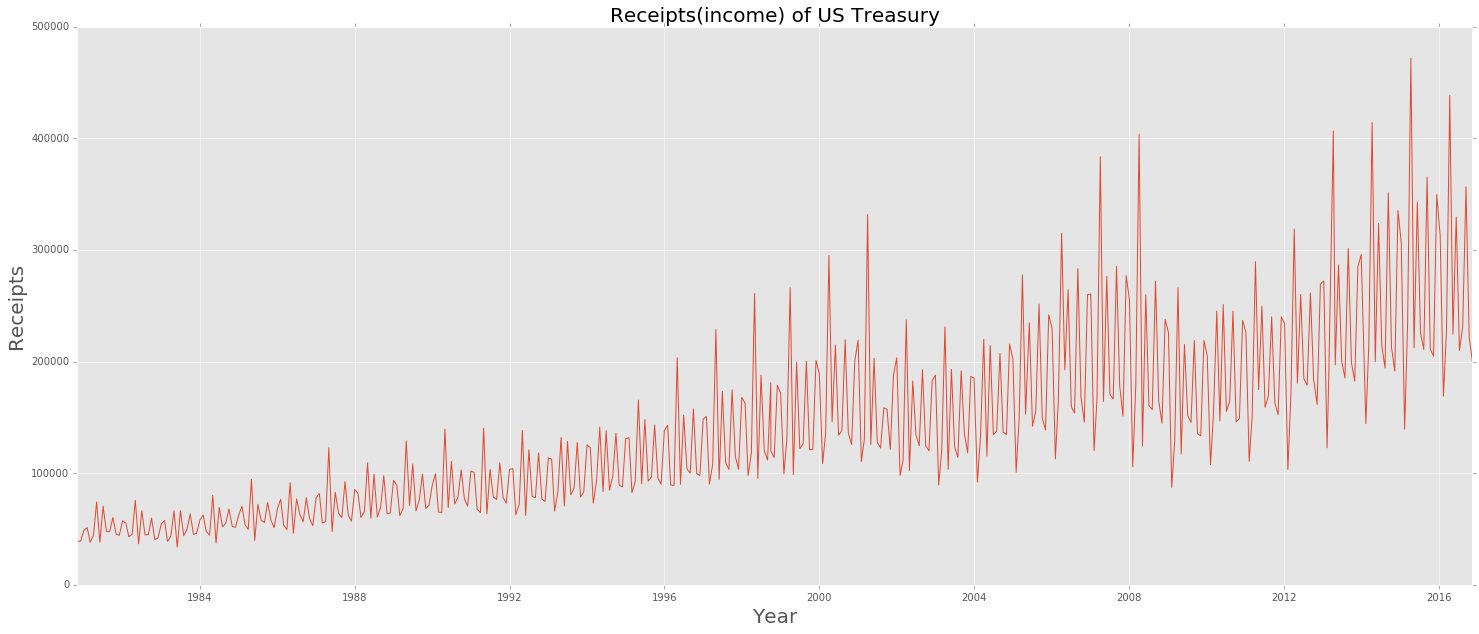

In [4]:
plt.figure(figsize=(25,10))
plt.title("Receipts(income) of US Treasury", fontsize=20)

plt.plot(data.index, data.Receipts)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Receipts", fontsize=20)


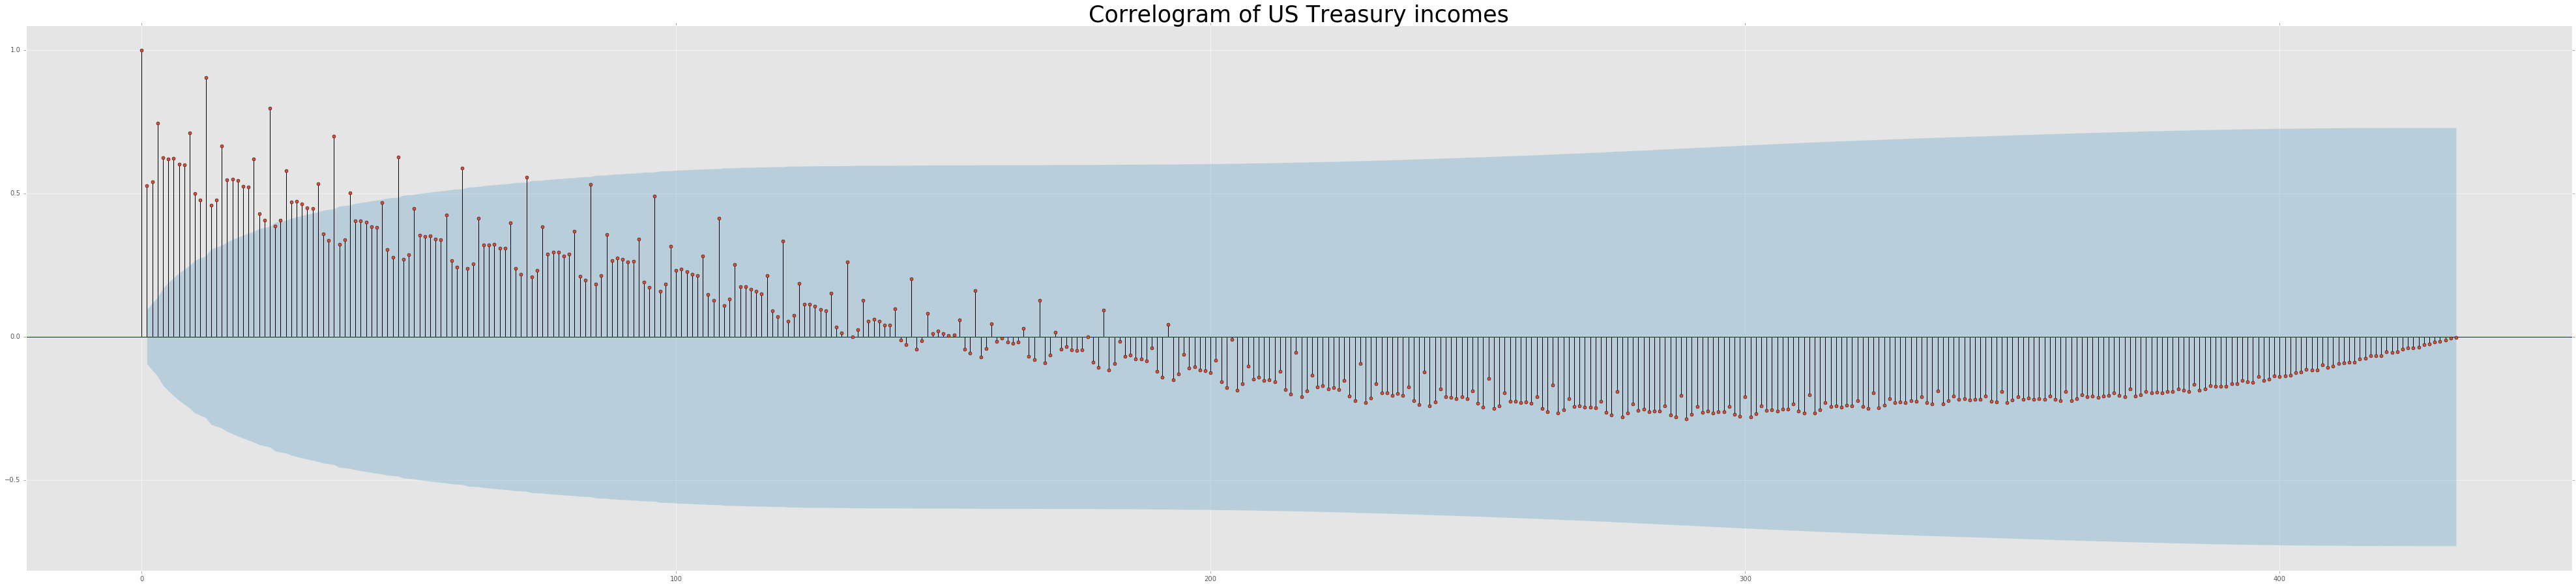

In [5]:
fig = tsaplots.plot_acf(data.Receipts, ax=None)
plt.title("Correlogram of US Treasury incomes", fontsize=35)
fig.set_figwidth(70)
fig.set_figheight(15)

* по коррелолограмме выше можем видеть выраженную сезонность - в лагах кратных сезону(конец года) - "ямы"
* также, виден тренд
--- 
#### Стационарность ряда. Приведение к стационарному

* Проверим на стационарность исходный ряд, воспользовавшись критерием Дикка-Фуллера.
* $H_0$ - нулевая гипотеза, ряд нестационарен
* $H_1$ - альтернативная гипотеза, о том, что ряд стационарен

Критерий Дики-Фуллера: p=0.911776


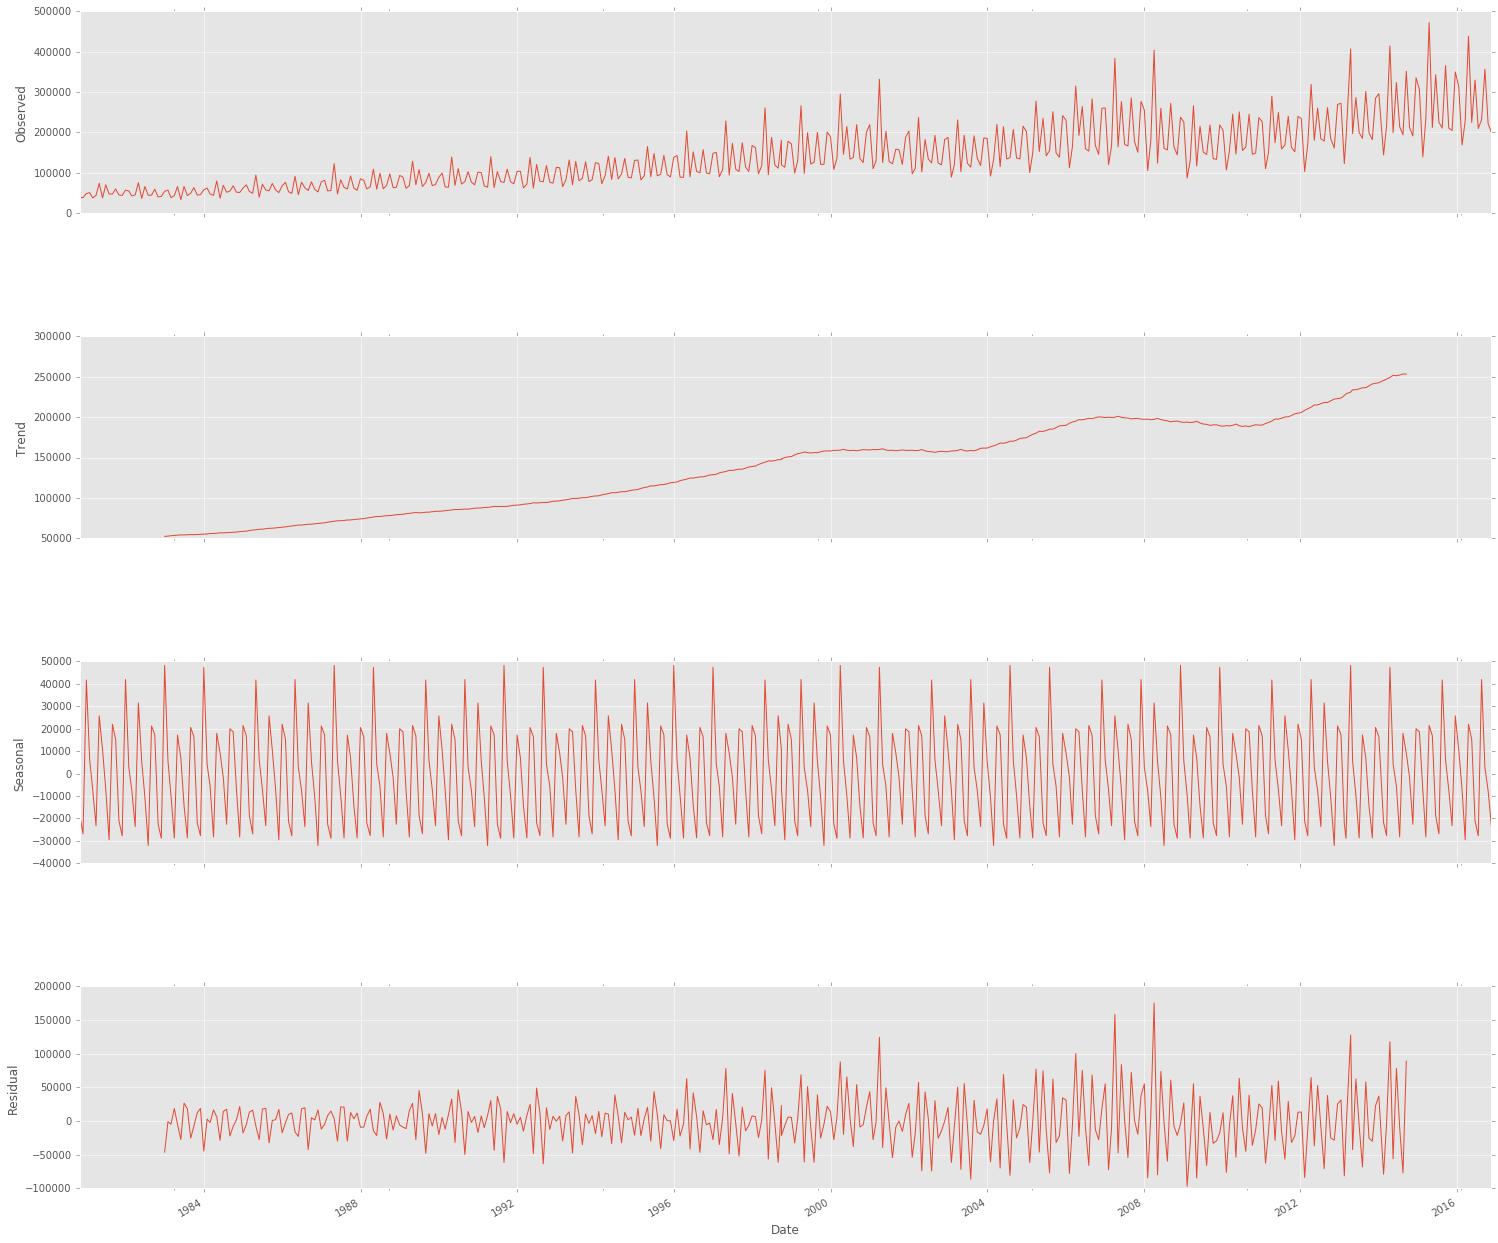

In [6]:
fig = sm.tsa.seasonal_decompose(data["Receipts"], freq=52).plot()
fig.set_figwidth(25)
fig.set_figheight(22)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Receipts)[1])
#ряд нестационарен

* Полученное $p-$value показывает, что мы не отвергаем нулевую гипотезу о нестационарности ряда
* По изображению выше видим, что исходный ряд нестационарен(график Trend из STL-декомпозиции)
* Также, хорошо видим сезонность по Seasonal 
---
#### Стабилизация дисперсии
* Для начала, стабилизируем дисперсию преобразованием Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.042756
Критерий Дики-Фуллера: p=0.825347


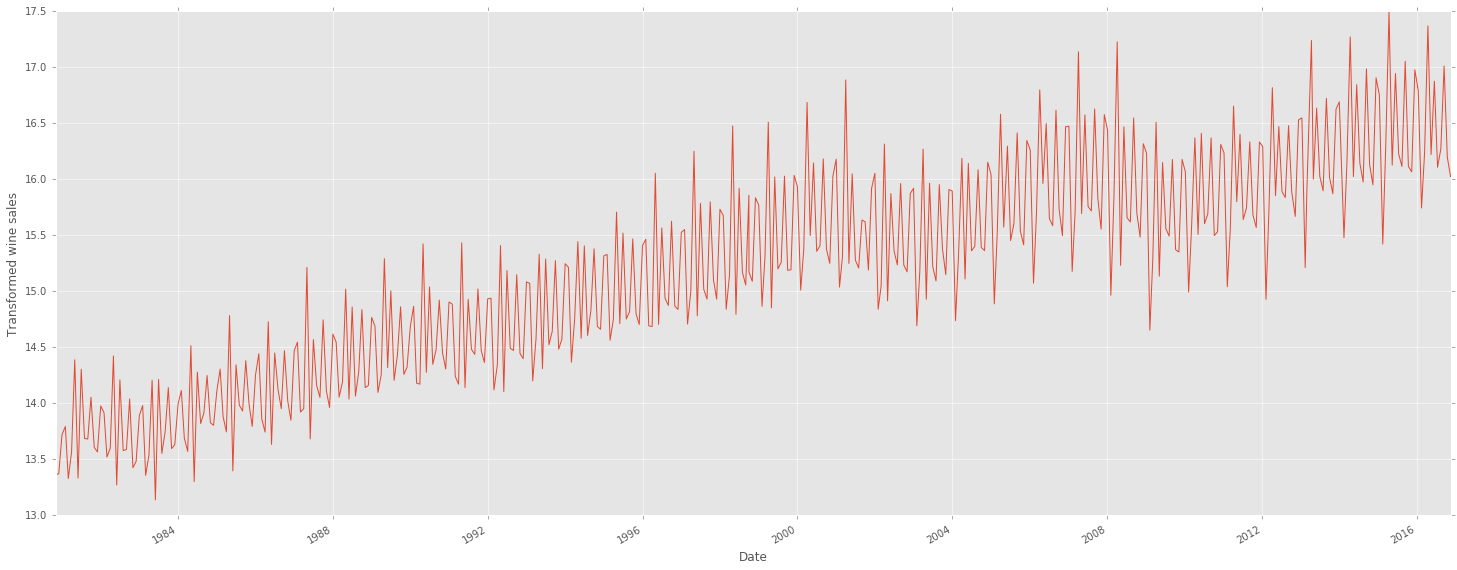

In [13]:
data["Receipts_box"], lmbda = stats.boxcox(data.Receipts)
plt.figure(figsize=(25,10))
data.Receipts_box.plot()
plt.ylabel('Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Receipts_box)[1])

* можем видеть, что дисперсия ряда в начале и в конце стали примерно равны и это хорошо видно по преобразованному ряду
* тем не менее, $p$-value хоть и уменьшилось, но не настолько, чтобы принимать альтернативную гипотезу
---
#### Дифферинцирование ряда
* Как уже было сказано, сезонность ряда хорошо видно по коррелограмме, поэтому продифференцируем ряд на 12 месяцев


Критерий Дики-Фуллера: p=0.000199


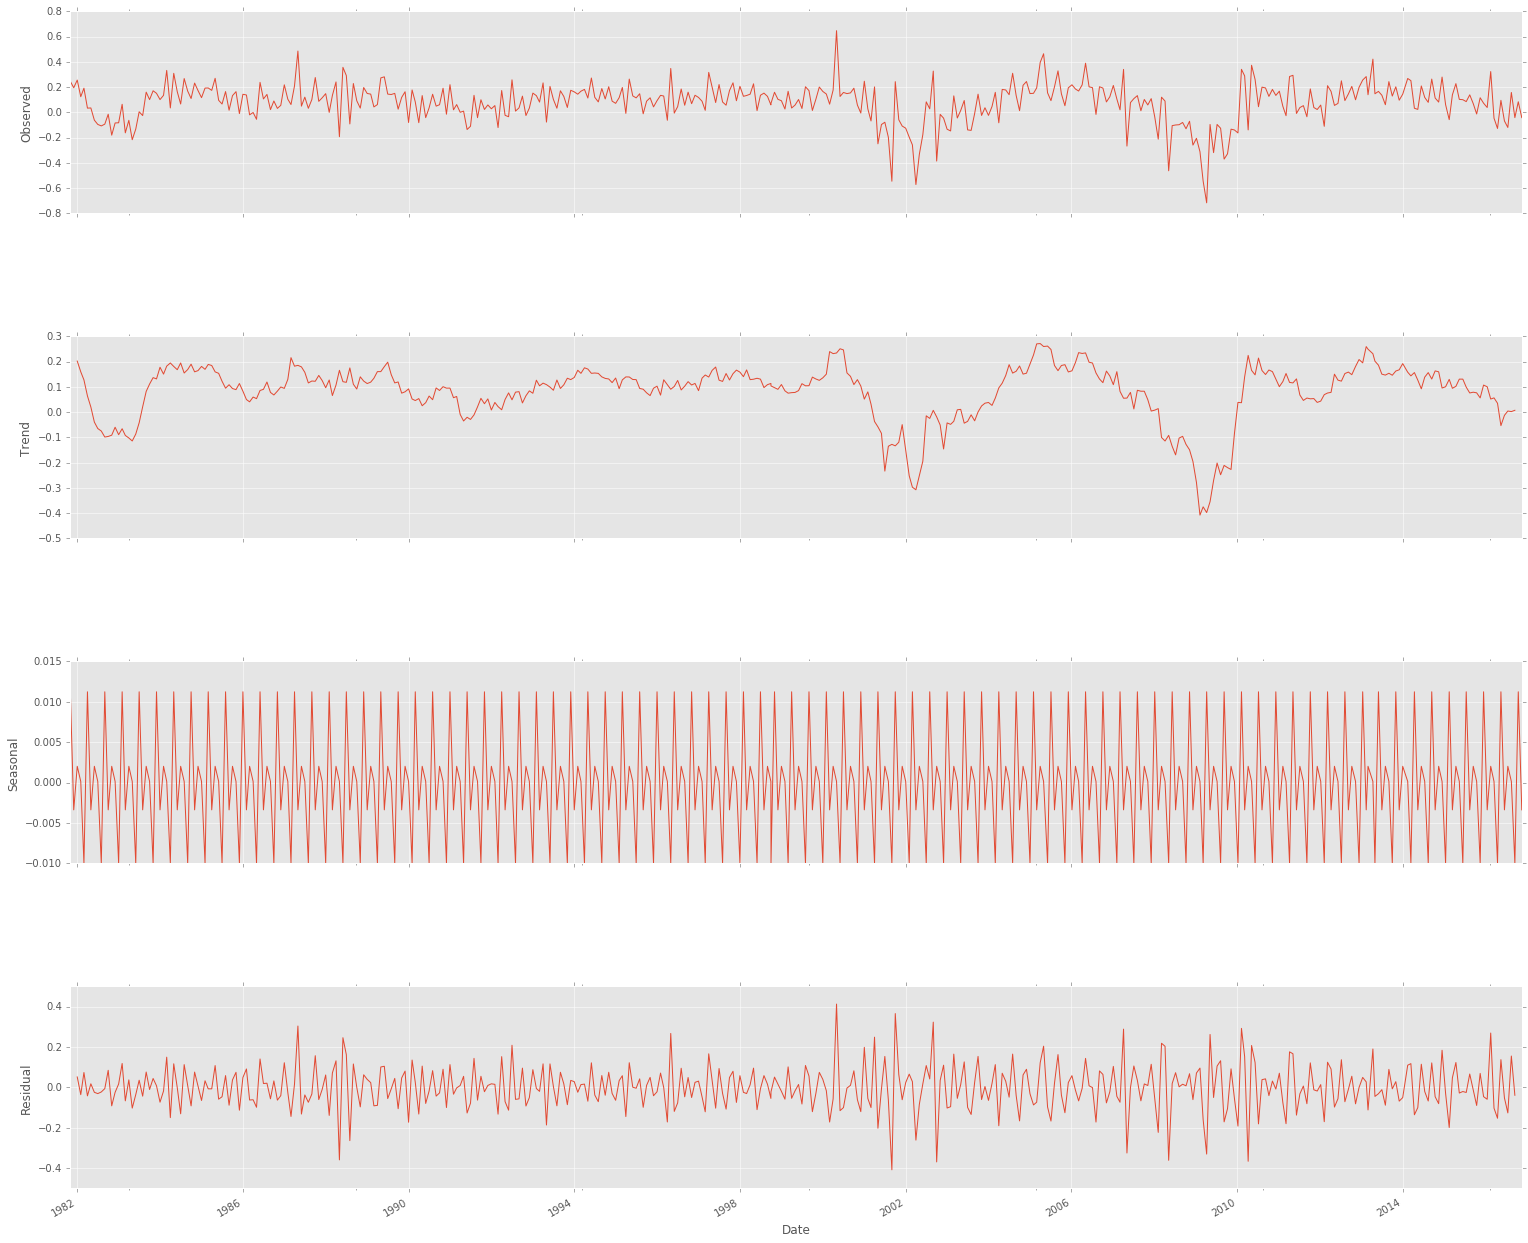

In [8]:
data['Receipts_season_box'] = data.Receipts_box - data.Receipts_box.shift(12)
fig = sm.tsa.seasonal_decompose(data.Receipts_season_box[12:], freq=5).plot()
fig.set_figwidth(25)
fig.set_figheight(22)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Receipts_season_box[12:])[1])

* Хоть и $p$-value для сезонно продифферинцированного ряда говорит о том, что можно принимать альтернативную гипотезу, тренд на STL-композиции все равно выглядит не до конца "шумовым"
* Чтобы это устранить, продифферинцируем ряд еще раз, но на 1 месяц

Критерий Дики-Фуллера: p=0.000000


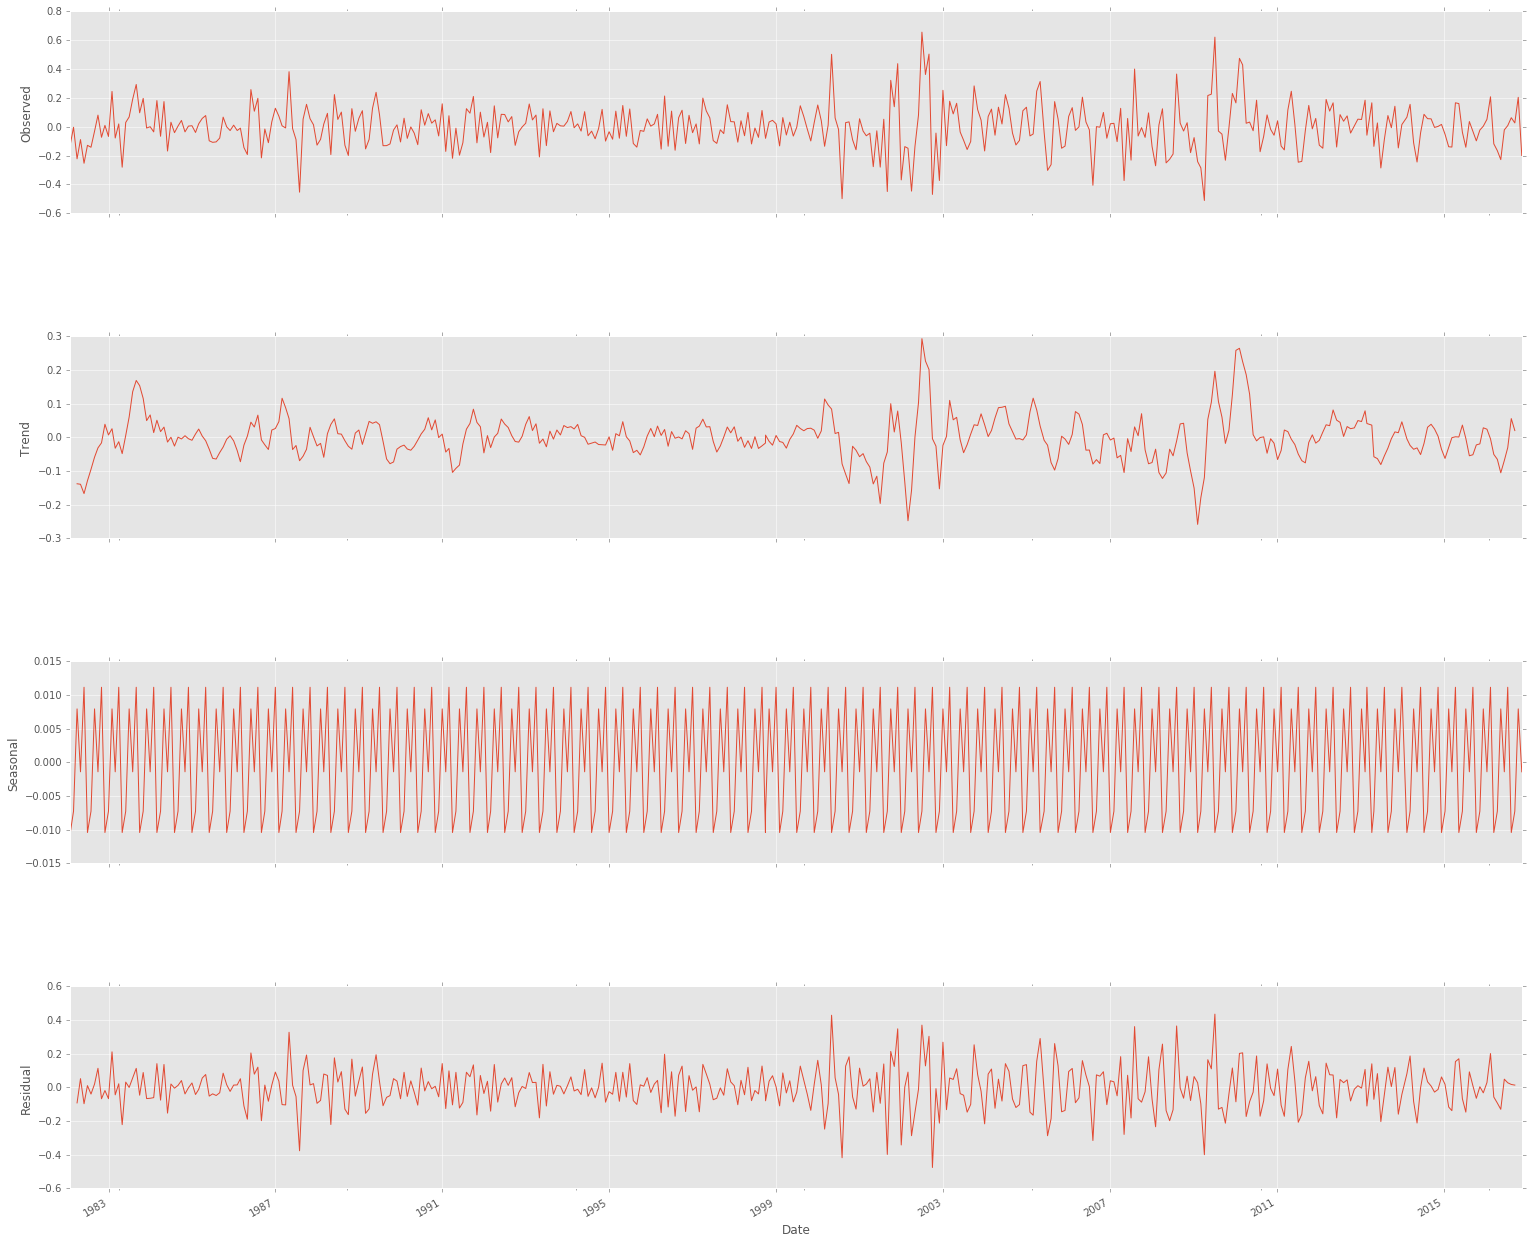

In [16]:
data['Receipts_season_box_diff'] = data.Receipts_season_box - data.Receipts_season_box.shift(3)
fig = sm.tsa.seasonal_decompose(data.Receipts_season_box_diff[15:], freq=5).plot()
fig.set_figwidth(25)
fig.set_figheight(22)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Receipts_season_box_diff[15:])[1])

* Можем видеть, что после сезонного дифференцирования(с периодом 12 месяцев) и обычного дифферинцирования на 1 месяц тренда больше не наблюдается и график Trend колеблется на одном уровне
* Полученное $p$-value позволяет нам с уверенностью принять альтернативную гипотезу о стационарности ряда
---
#### Выбор начальных приближений модели предсказания
* Построим автокорреляционную и частичную автокорреляционную функции ряда после преобразований выше и приведением исходного ряда к стационарному

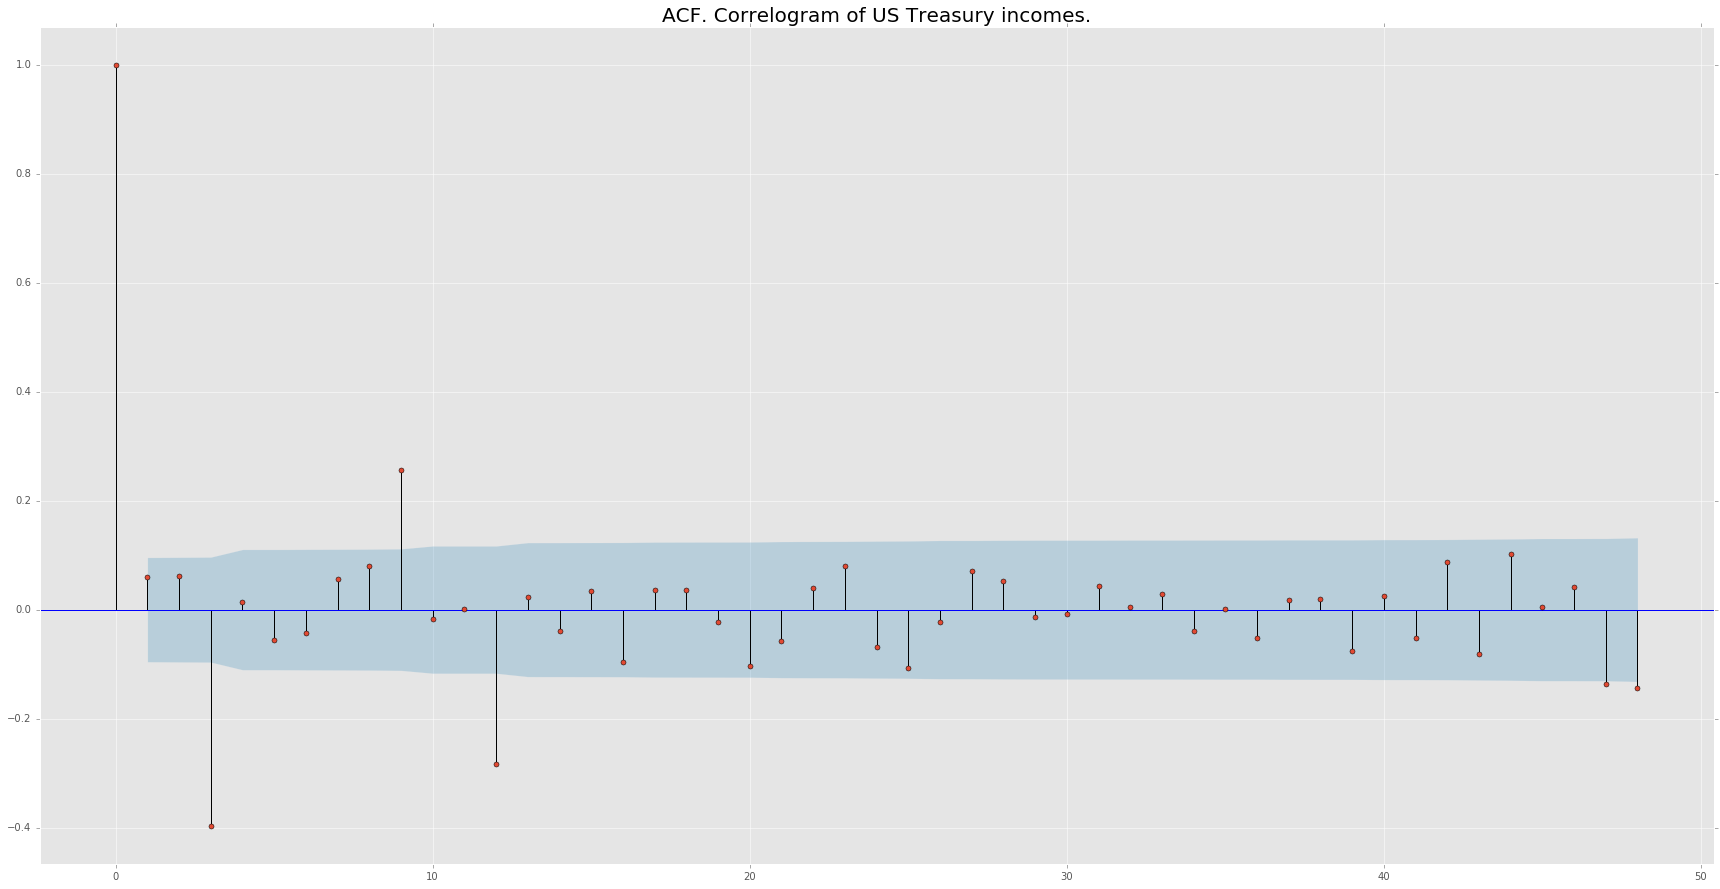

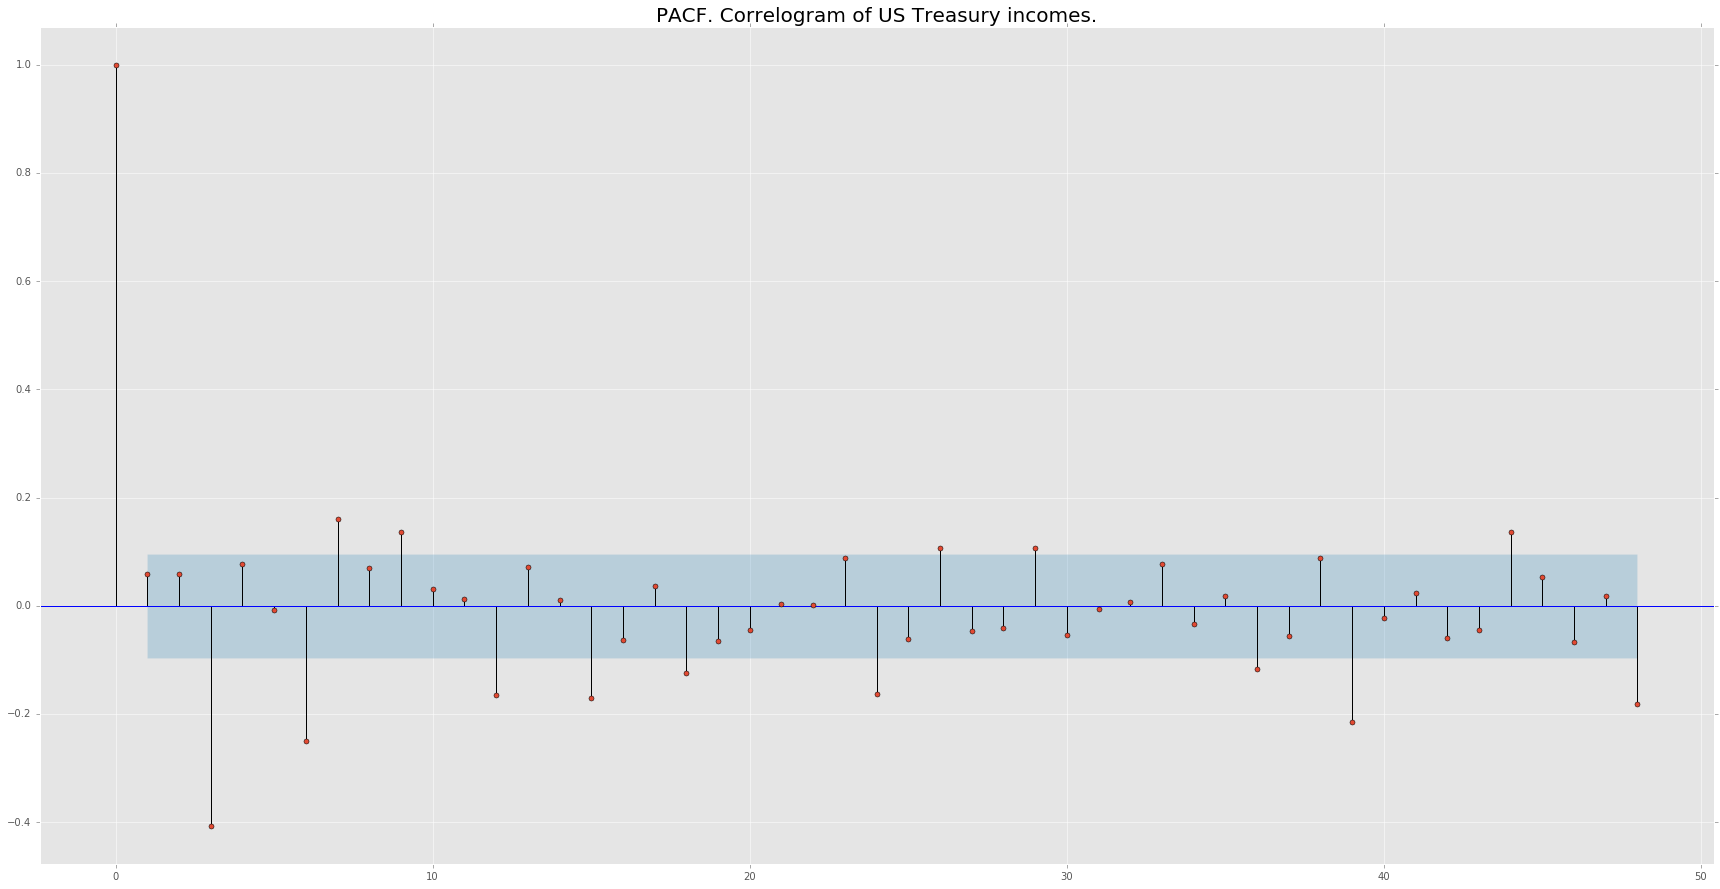

In [17]:
fig = tsaplots.plot_acf(data.Receipts_season_box_diff[15:], ax=None, lags=48)
plt.title("ACF. Correlogram of US Treasury incomes.", fontsize=20)
fig.set_figwidth(30)
fig.set_figheight(15)

fig = tsaplots.plot_pacf(data.Receipts_season_box_diff[15:], ax=None, lags=48)
plt.title("PACF. Correlogram of US Treasury incomes.", fontsize=20)
fig.set_figwidth(30)
fig.set_figheight(15)

* максимальный сезонный лаг(выходящий из синего "коридора", значимо отличающееся значение автокорреляции) принимает значение 4, значит начальным приближением для $Q$ будет 1
* кол-во значимо отличимых от нуля  значений автокорреляции на ACF равно 3 - это будет начальным приближением для $q$
* $P$ - 2, т.к. номер последнего значения автокорреляции значимо отличающейся от нуля соответствует 13
* $p$ - 5, количество значимо отличимых от нуля несезонных значений автокорреляций на PACF
---
#### Выбор модели SARIMA
* для выбора модели определим функцию $\texttt{choose_model}$, которая принимает временной ряд и начальный приближения параметров Q, q, P, p
* будем давать этой функции ряд после преобразования Бокса-Кокса, т.к. он никак не влияет на него и лишь стабилизирует дисперсии
* понятно, что для прогнозирования нужно будет учесть факт выше

In [83]:
def choose_model(data, Q, q, P, p):
    Q_range = range(0, Q)
    q_range = range(0, q)
    P_range = range(0, P)
    p_range = range(0, p)
    
    d, D = 3, 1
    
    parameters = product(p_range, q_range, P_range, Q_range)
    parameters_list = list(parameters)
    
    %%time
    results = []
    best_aic = float("inf")

    for param in parameters_list:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору 
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
            
        results.append([param, model.aic])
    return best_model, results

In [84]:
best_sarima, results = choose_model(data.Receipts_box[15:], 1, 3, 2, 5)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.2 µs
wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 1, 0, 0)
wrong parameters: (0, 1, 1, 0)
wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (1, 1, 0, 0)
wrong parameters: (1, 1, 1, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (4, 1, 0, 0)
wrong parameters: (4, 1, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)


In [85]:
print(best_sarima.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       Receipts_box   No. Observations:                  419
Model:             SARIMAX(3, 3, 1)x(1, 1, 0, 12)   Log Likelihood                 157.132
Date:                            Thu, 15 Dec 2016   AIC                           -302.264
Time:                                    17:14:54   BIC                           -278.037
Sample:                                01-31-1982   HQIC                          -292.688
                                     - 11-16-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2987      0.040    -32.412      0.000      -1.377      -1.220
ar.L2         -1.0698      0.051   

Критерий Стьюдента: p=0.469135
Критерий Дики-Фуллера: p=0.000000


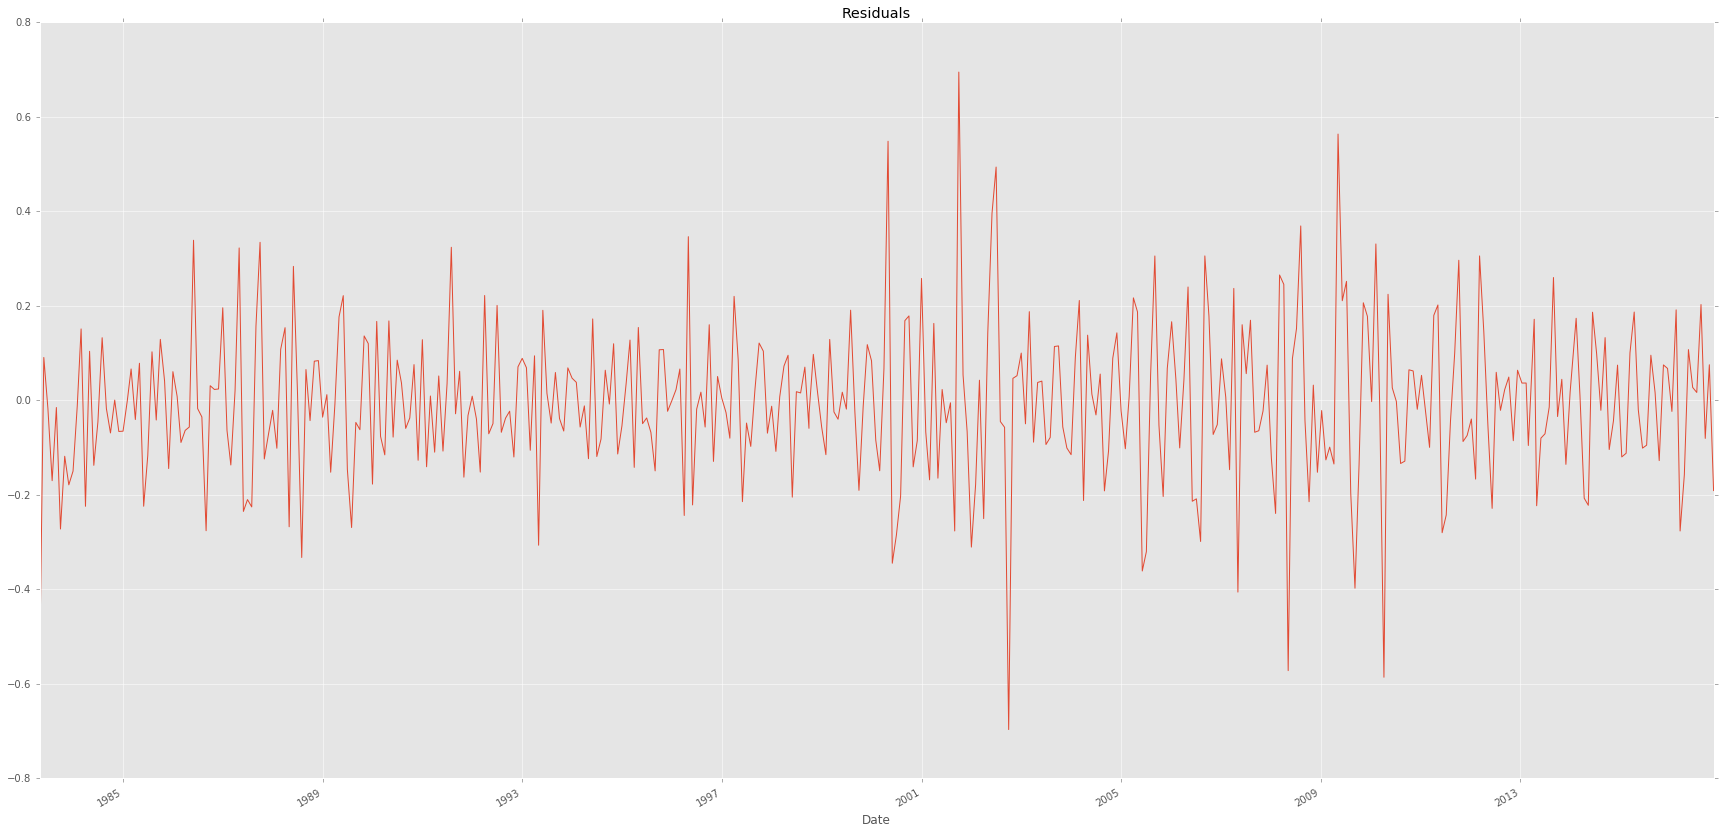

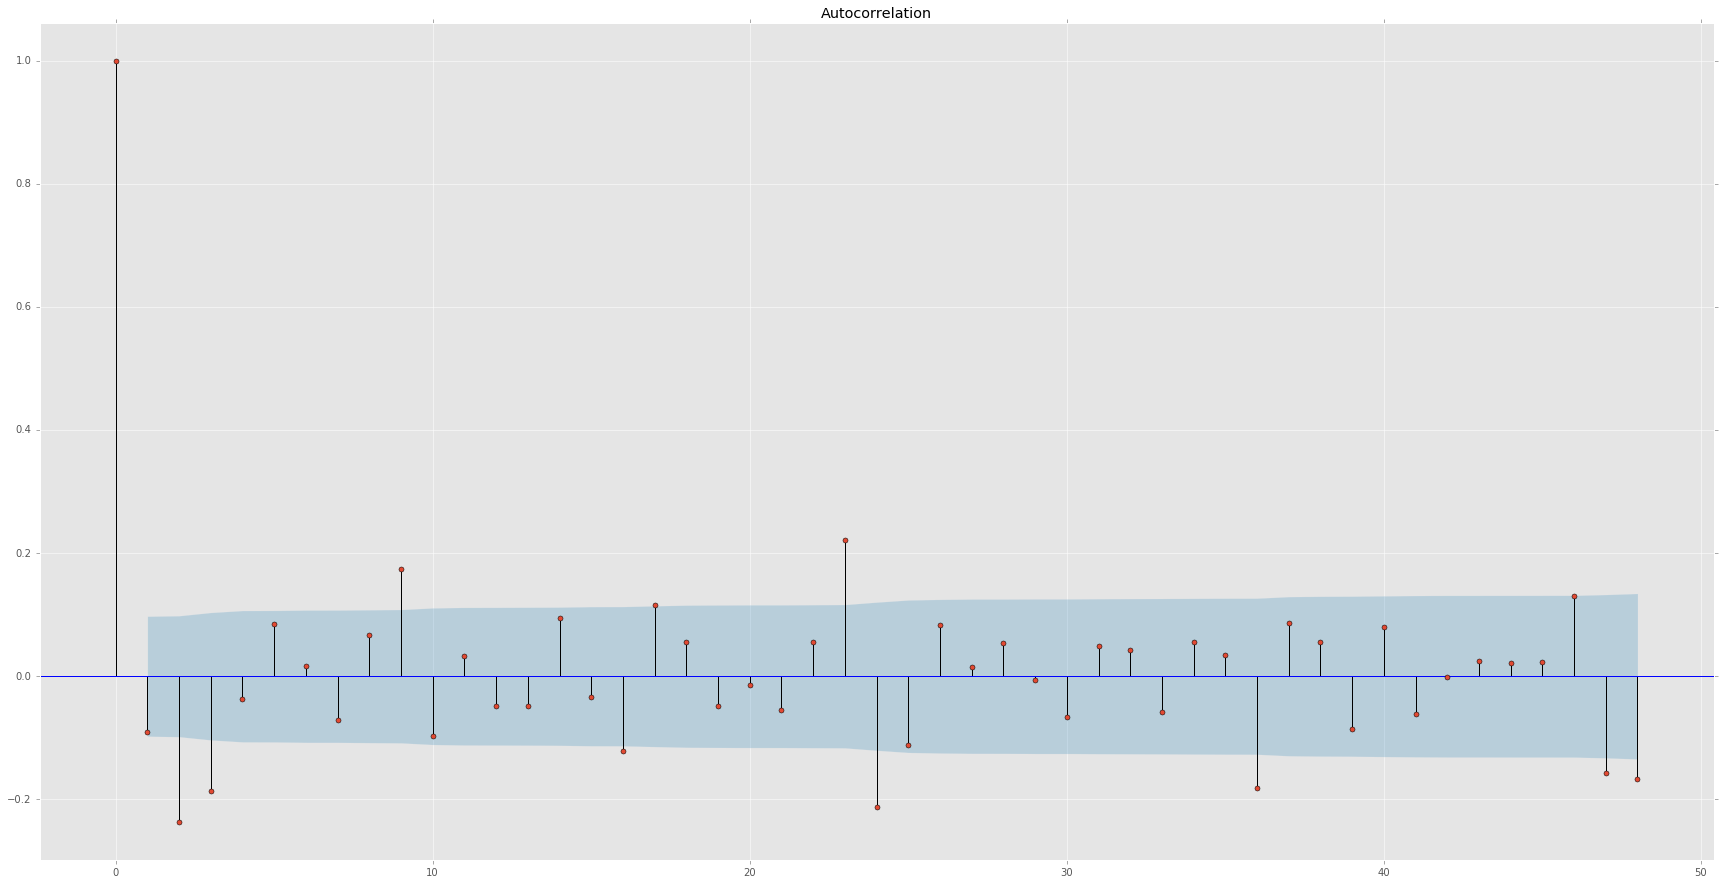

In [86]:
fig = best_sarima.resid[15:].plot(figsize=(30, 15))
plt.title('Residuals')

fig = sm.graphics.tsa.plot_acf(best_sarima.resid[15:].values.squeeze(), lags=48)
fig.set_figwidth(30)
fig.set_figheight(15)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_sarima.resid[15:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_sarima.resid[15:])[1])

* В несмещенности остатков можно убедиться с помощью критерия Стьюдента - $p$-value дает основание принять пльтернативную гипотезу о несмещенности.
* Их стационарность видна визуально и по $p$-value критерия Дикки-Фуллера
* По коррелолограме и критерию Льюнга-Бокса можно сказать о неавтокоррелированности
---
### Результат модели. Прогнозирование
* как отмечалось ранее, обучение моделей для выбора осуществлялось на преобразованном Боксом и Коксом ряде, поэтому для отображения результата модели, нужно обратить предсказание модели

In [87]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

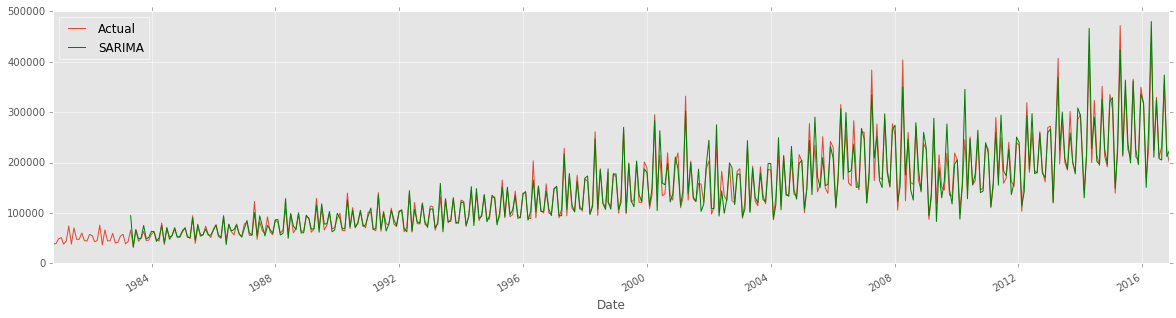

In [99]:
data['model'] = invboxcox(best_sarima.fittedvalues, lmbda)
plt.figure(figsize=(20,5))
data.Receipts.plot(label="Actual")
data.model[30:].plot(color='g', label="SARIMA")
plt.legend(loc=2)

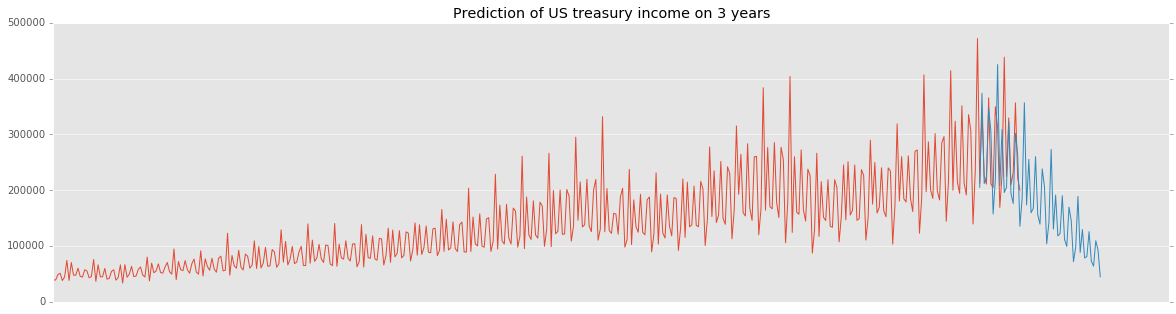

In [352]:
plt.figure(figsize=(20, 5))
plt.plot(data.Receipts.values)
plt.plot(invboxcox(best_sarima.predict(start=415, end=469), lmbda))
plt.xticks([])
plt.title("Prediction of US treasury income on 3 years")

* метод $\texttt{predict}$ упорно не давал строить прогноз со значением аргумента start превышающих 415.
* по этой причине построил прогноз просто преобразовав к $\texttt{np.array}$